# Classification Modeling - By Hotel

---

The initial modeling results revealed challenges in accurately classifying reservations, which may stem from significant differences between the two types of hotels in the dataset and from class imbalances in the data. To address these issues, I will train and evaluate separate models for each hotel in this notebook. While this approach is more time and resource-intensive than the combined model—a factor to consider in a production environment—splitting the dataset and developing individual models will help account for the unique characteristics and reservation patterns of each hotel.

Additionally, to tackle the class imbalance inherent in the dataset, I will employ SMOTE with Tomek Links. This technique combines the Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic examples of the minority class with Tomek Links to remove overlapping instances from the majority class. By integrating this resampling method into the modeling pipeline, I aim to create a more balanced and cleaner dataset. This combined strategy is expected to enhance classification performance by leveraging hotel-specific insights and effectively addressing the class imbalance.



---

# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# import shap

In [2]:
# from sklearnex import patch_sklearn
# patch_sklearn()

In [3]:
# from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

set_config(transform_output='pandas')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


# Load Data

In [4]:
df_data = pd.read_parquet('../../data/3.2_data_with_occupancies.parquet')
df_data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,...,Fourier_Annual_Sin_2,Fourier_Annual_Cos_2,Fourier_Annual_Sin_3,Fourier_Annual_Cos_3,Fourier_Monthly_Sin_2,Fourier_Monthly_Cos_2,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,0,342,2015,July,27,1,2,0.0,0,BB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,41,0.115169,0.115169
56,0,149,2015,July,27,1,2,1.0,0,BB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,201,0.115169,0.564607
57,0,149,2015,July,27,1,2,0.0,0,BB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,201,0.115169,0.564607
58,0,145,2015,July,27,1,2,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,201,0.115169,0.564607
59,0,110,2015,July,27,1,3,0.0,0,BB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,172,0.115169,0.483146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119362,0,4,2017,August,35,31,2,0.0,0,SC,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,102,0.761236,0.286517
119366,0,198,2017,August,35,31,2,0.0,0,SC,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,154,0.761236,0.432584
119372,0,332,2017,August,35,31,2,0.0,0,BB,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,154,0.761236,0.432584
119380,0,109,2017,August,35,31,2,0.0,0,BB,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,22,0.761236,0.061798


# Split By Hotel Number

In [5]:
df_data = df_data[df_data['HotelNumber'] == 'H2']
df_data = df_data.reset_index(drop=True)
df_data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,...,Fourier_Annual_Sin_2,Fourier_Annual_Cos_2,Fourier_Annual_Sin_3,Fourier_Annual_Cos_3,Fourier_Monthly_Sin_2,Fourier_Monthly_Cos_2,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,0,257,2015,July,27,1,1,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,108,0.115169,0.303371
1,0,257,2015,July,27,1,2,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,108,0.115169,0.303371
2,0,257,2015,July,27,1,2,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,108,0.115169,0.303371
3,0,257,2015,July,27,1,2,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,108,0.115169,0.303371
4,0,257,2015,July,27,1,2,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,108,0.115169,0.303371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,4,2017,August,35,31,2,0.0,0,SC,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,102,0.761236,0.286517
79326,0,198,2017,August,35,31,2,0.0,0,SC,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,154,0.761236,0.432584
79327,0,332,2017,August,35,31,2,0.0,0,BB,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,154,0.761236,0.432584
79328,0,109,2017,August,35,31,2,0.0,0,BB,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,22,0.761236,0.061798


In [6]:
# df_data.columns.to_list()

In [7]:
# selected_features = ['LeadTime',
#  'ArrivalDateYear',
#  'ArrivalDateMonth',
#  'ArrivalDateWeekNumber',
#  'ArrivalDateDayOfMonth',
#  'Adults',
#  'Children',
#  'Babies',
#  'Meal',
#  'Country',
#  'MarketSegment',
#  'DistributionChannel',
#  'IsRepeatedGuest',
#  'PreviousCancellations',
#  'PreviousBookingsNotCanceled',
#  'ReservedRoomType',
#  'AssignedRoomType',
#  'BookingChanges',
#  'DepositType',
#  'Agent',
#  'Company',
#  'DaysInWaitingList',
#  'CustomerType',
#  'ADR',
#  'RequiredCarParkingSpaces',
#  'TotalOfSpecialRequests',
#  'ReservationStatus',
#  'HotelNumber',
#  'ArrivalDate',
#  'DepartureDate',
#  'Length of Stay',
#  'BookingDate',
#  'ArrivalDate_DaysBeforeHoliday',
#  'ArrivalDate_DaysAfterHoliday',
#  'DepartureDate_DaysBeforeHoliday',
#  'DepartureDate_DaysAfterHoliday',
#  'BookingDate_DaysBeforeHoliday',
#  'BookingDate_DaysAfterHoliday',
#  'ArrivalDate_DayOfWeek',
#  'occupancy_at_arrival',
#  'occupancy_at_departure',
#  'occupancy_pct_at_arrival',
#  'occupancy_pct_at_departure']

In [8]:
# df_data = df_data[selected_features]
df_data = df_data.drop(columns=['ArrivalDate', 'DepartureDate','ReservationStatus', 'DepartureDate'])
df_data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,...,Fourier_Annual_Sin_2,Fourier_Annual_Cos_2,Fourier_Annual_Sin_3,Fourier_Annual_Cos_3,Fourier_Monthly_Sin_2,Fourier_Monthly_Cos_2,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,0,257,2015,July,27,1,1,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,108,0.115169,0.303371
1,0,257,2015,July,27,1,2,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,108,0.115169,0.303371
2,0,257,2015,July,27,1,2,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,108,0.115169,0.303371
3,0,257,2015,July,27,1,2,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,108,0.115169,0.303371
4,0,257,2015,July,27,1,2,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,108,0.115169,0.303371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,4,2017,August,35,31,2,0.0,0,SC,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,102,0.761236,0.286517
79326,0,198,2017,August,35,31,2,0.0,0,SC,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,154,0.761236,0.432584
79327,0,332,2017,August,35,31,2,0.0,0,BB,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,154,0.761236,0.432584
79328,0,109,2017,August,35,31,2,0.0,0,BB,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,22,0.761236,0.061798


# Train/Test Split

In [11]:
target_feature = 'IsCanceled'

X = df_data.drop(columns=target_feature)
y = df_data[target_feature]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify=y)

In [14]:
y_train.value_counts(normalize=True).round(2)

IsCanceled
0    0.58
1    0.42
Name: proportion, dtype: float64

In [15]:
y_test.value_counts(normalize=True).round(2)

IsCanceled
0    0.58
1    0.42
Name: proportion, dtype: float64

# Model: Random Forest Classifer - Baseline

In [ ]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              min_frequency=5,
                              max_categories=25))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Build the full pipeline without SMOTE resampling
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42,
                                          class_weight='balanced_subsample'))
])

# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=10,
                      shuffle=True,
                      random_state=42)

## Model Results

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     46228
           1       0.90      0.82      0.86     33102

    accuracy                           0.89     79330
   macro avg       0.89      0.88      0.88     79330
weighted avg       0.89      0.89      0.89     79330



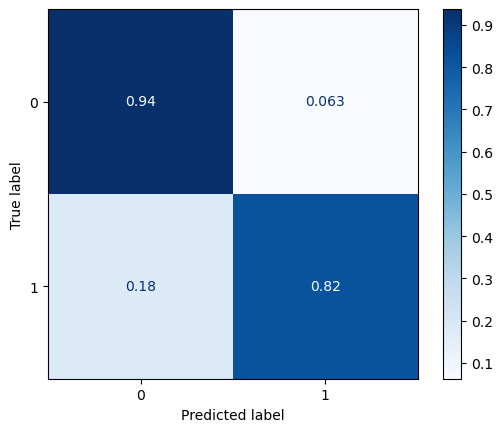

In [17]:
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

print(classification_report(y, y_pred))

ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

## *Reminder: Identifying Model Labels*

---

Scikit-Learn alphabetically encodes text labels.

In this case, **"Cancelled" reservations are mapped to 1, and "Checked-Out" reservations are mapped to 0.**

### Tree Depths

In [18]:
# Access the fitted model
model_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

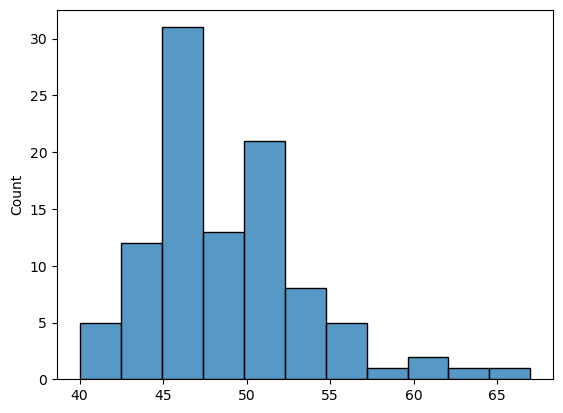

In [19]:
# Get the depths of the trees in the fitted model
depths = [tree.get_depth() for tree in model_pipeline[-1].estimators_]

# Plot the histogram of tree depths
sns.histplot(depths);

# Performing SMOTE to Handle Class Imbalance

---

1. Use preprocessor outside of pipeline to OHE categoricals
2. Check results
3. Create boolean index to identify which columns to treat as categoricals
4. Instantiate a SMOTENC object
5. Reset `set_config` setting to "default" due to compatibility issues
6. Use `.fit_resample` method to perform SMOTENC
7. Reset `set_config` back to "pandas" and convert output data back to DataFrames
8. Confirm OHE'ed categoricals consist only of numeric features again.

---

In [20]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [21]:
X_train_transformed.head()

,num__LeadTime,num__ArrivalDateWeekNumber,num__Adults,num__Children,num__Babies,num__IsRepeatedGuest,num__PreviousCancellations,num__PreviousBookingsNotCanceled,num__BookingChanges,num__DaysInWaitingList,...,cat__Company_ 242,cat__Company_ 280,cat__Company_ 348,cat__Company_ 385,cat__Company_ NULL,cat__Company_infrequent_sklearn,cat__CustomerType_Contract,cat__CustomerType_Group,cat__CustomerType_Transient,cat__CustomerType_Transient-Party
14901,59.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
14920,9.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
71199,108.0,25.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
56598,38.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
21697,101.0,16.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [22]:
cat_features = [col.startswith('cat_') for col in X_train_transformed.columns]
cat_features

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [23]:
## Reset output settings to default for SMOTE
set_config(transform_output='default')

## Perform SMOTE resampling
snc = SMOTENC(categorical_features=cat_features, random_state = 42)
X_train_smote, y_train_smote = snc.fit_resample(X_train_transformed, y_train)

In [27]:
## Reset output settings to pandas
set_config(transform_output='pandas')

X_train_smote = pd.DataFrame(X_train_smote, columns=X_train_transformed.columns)
y_train_smote = pd.Series(y_train_smote)

In [28]:
X_train_smote.nunique()

num__LeadTime                        4816
num__ArrivalDateWeekNumber           1469
num__Adults                          1692
num__Children                         672
num__Babies                            47
                                     ... 
cat__Company_infrequent_sklearn         2
cat__CustomerType_Contract              2
cat__CustomerType_Group                 2
cat__CustomerType_Transient             2
cat__CustomerType_Transient-Party       2
Length: 219, dtype: int64

# Model: Random Forest Classifier - SMOTENC

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     11557
           1       0.89      0.82      0.86      8276

    accuracy                           0.89     19833
   macro avg       0.89      0.88      0.88     19833
weighted avg       0.89      0.89      0.88     19833



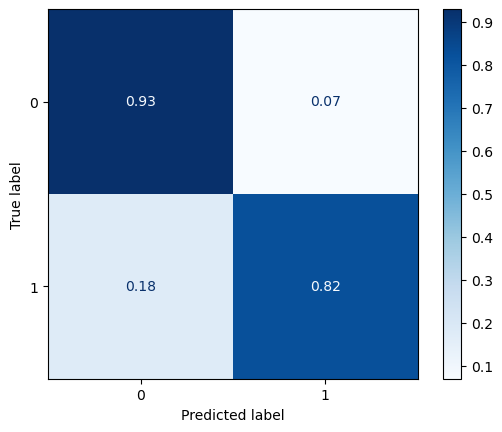

In [29]:
smotenc_model = model_pipeline[-1].fit(X_train_smote, y_train_smote)

y_pred = smotenc_model.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

# SHAP Results Review: Random Forest Classifier

### Non-SMOTE'ed Modeling Approach

In [25]:
# ## Use only if using model pipeline without SMOTENC
# X_train_xf = model_pipeline.named_steps.preprocessor.fit_transform(X_train)
# X_test_xf = model_pipeline.named_steps.preprocessor.transform(X_test)

# X_shap_train = shap.sample(X_train_xf, 500)
# y_shap_train = y_train.loc[X_shap_train.index]

# X_shap_test = shap.sample(X_test_xf, 500)
# y_shap_test = y_test.loc[X_shap_test.index]

# explainer = shap.Explainer(model_pipeline.named_steps.classifier, X_shap_train)
# # shap_values_train = explainer(X_shap_train)
# shap_values_test = explainer(X_shap_test)

### SMOTE-Based Modeling Approach

In [27]:
## Use only if using SMOTENC data and associated model

X_train_xf = X_train_smote
X_test_xf = X_test_transformed

X_shap_train = shap.sample(X_train_xf, 500)
y_shap_train = y_train_smote.loc[X_shap_train.index]

X_shap_test = shap.sample(X_test_xf, 500)
y_shap_test = y_test.loc[X_shap_test.index]

explainer = shap.Explainer(smotenc_model, X_shap_train)
# shap_values_train = explainer(X_shap_train)
shap_values_test = explainer(X_shap_test, check_additivity=False)

 99%|===================| 990/1000 [01:25<00:00]        

In [28]:
print(shap_values_test.shape)

(500, 182, 2)


## Summary Plot

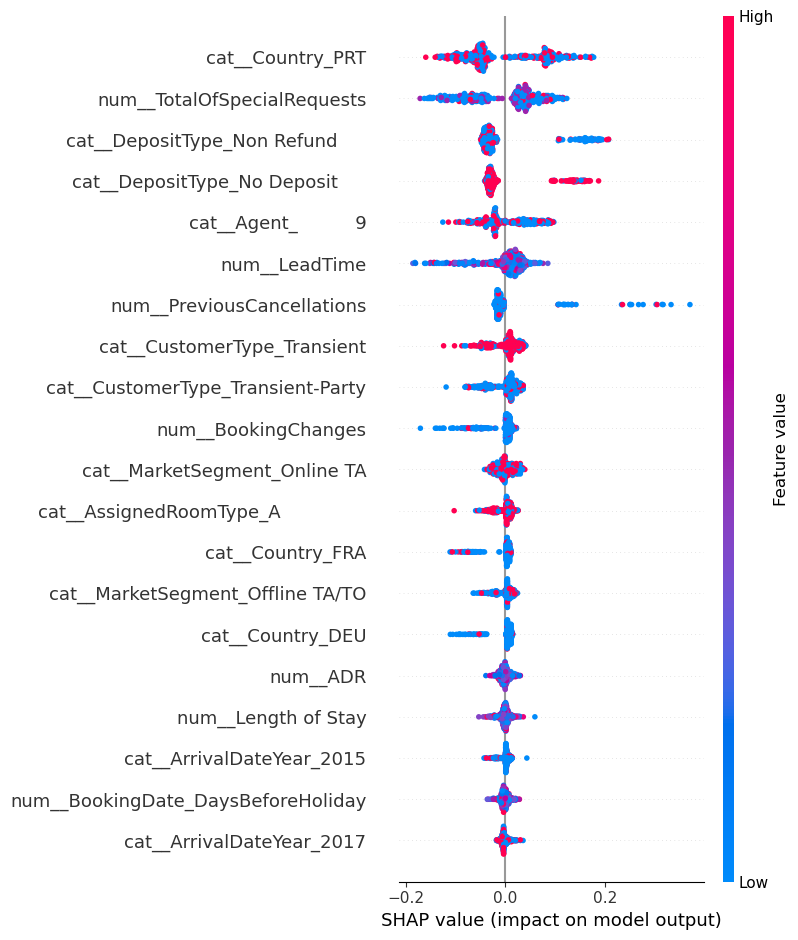

In [29]:
shap.summary_plot(shap_values_test[:, :, 1], X_shap_train)

## SHAP Analysis: Notable Features and Actionable Insights for Cancellations (Class 1)

This section outlines key insights from the SHAP analysis of the RandomForestClassifier (RFC) model for predicting **cancellations/no-shows (class 1)**. We identify the most influential features and propose actionable steps to reduce cancellations based on these results.

1. **Country (Portugal) - `cat__Country_PRT`**
   - **Insight**: Guests from Portugal (high feature values, red points) are more likely to cancel or no-show (positive SHAP values). Guests from other countries (low feature values, blue points) are less likely to cancel.
   - **Actionable Strategy**:
     - Implement targeted interventions for **Portuguese guests** who are more prone to cancellations. Offer incentives for **early commitment** or send **personalized reminders** before the reservation date to reduce the likelihood of cancellation.
     - Focus on guests from other countries with more generalized engagement strategies.

2. **Required Car Parking Spaces - `num__RequiredCarParkingSpaces`**
   - **Insight**: Guests who request more parking spaces (high feature values, red points) are less likely to cancel. Conversely, guests who request no parking spaces (low feature values, blue points) are more likely to cancel.
   - **Actionable Strategy**:
     - For guests who do not request parking spaces, consider offering **transportation incentives** such as **shuttle services**, **discounts on public transportation**, or **local transport deals**. This may increase their commitment to their reservation and reduce cancellations.

3. **Lead Time - `num__LeadTime`**
   - **Insight**: Short lead times (low feature values, blue points) are associated with higher cancellation rates. Guests who book closer to the arrival date are more likely to cancel. In contrast, guests with longer lead times (high feature values, red points) are less likely to cancel.
   - **Actionable Strategy**:
     - For guests with **short lead times**, offer **flexible booking options** like free cancellation up to a specific point, or provide **last-minute incentives** to encourage them to commit. For guests with **long lead times**, provide additional offers to keep them engaged and reduce the chances of them reconsidering their booking.

4. **Special Requests - `num__TotalOfSpecialRequests`**
   - **Insight**: Guests with more special requests (high feature values, red points) are less likely to cancel, whereas those with fewer or no special requests (low feature values, blue points) are more likely to cancel.
   - **Actionable Strategy**:
     - **Encourage engagement** by promoting the option to make special requests during the booking process. Highlight room upgrades, additional services, or in-room amenities, which can increase guest involvement and commitment, reducing the likelihood of cancellations.

5. **Deposit Type (Non-Refundable) - `cat__DepositType_Non Refund`**
   - **Insight**: Guests with non-refundable deposits (high feature values, red points) are far less likely to cancel, while refundable deposits (low feature values, blue points) increase the likelihood of cancellation.
   - **Actionable Strategy**:
     - **Encourage non-refundable bookings** by offering discounts or perks (e.g., room upgrades or complimentary services) for guests who select the non-refundable option. This can increase commitment and reduce cancellations. For refundable bookings, consider sending reminders or offering additional services to reduce cancellation risk.
   
---

**Summary**

To reduce cancellations, focus on **incentivizing guests with short lead times**, **engaging guests with no parking requests** by offering transport-related services, and encouraging **special requests** during the booking process to boost engagement. Additionally, promoting **non-refundable bookings** with incentives can lead to fewer cancellations. By targeting key behaviors and preferences (such as lead time, special requests, and deposit types), the likelihood of cancellations can be minimized.

---

# Model: `HistGradientBoostingClassifier` - Baseline

In [30]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              min_frequency=5,
                              max_categories=25))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Build the full pipeline without SMOTE resampling
hgbc_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42,
                                                  class_weight='balanced'))
])

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     46228
           1       0.84      0.85      0.85     33102

    accuracy                           0.87     79330
   macro avg       0.87      0.87      0.87     79330
weighted avg       0.87      0.87      0.87     79330



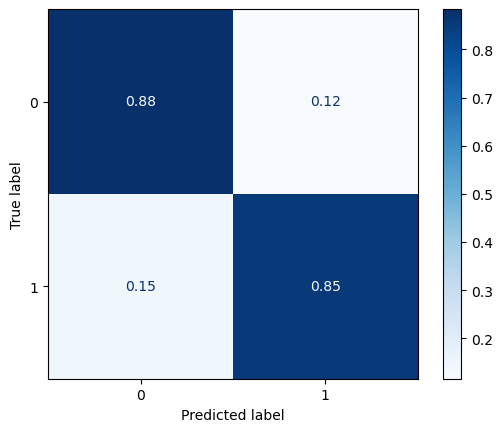

In [31]:
# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred = cross_val_predict(hgbc_model_pipeline, X, y, cv=skf, n_jobs=-1)

print(classification_report(y, y_pred))

ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

# Model: `HistGradientBoostingClassifier` - SMOTENC

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     11557
           1       0.86      0.83      0.85      8276

    accuracy                           0.87     19833
   macro avg       0.87      0.87      0.87     19833
weighted avg       0.87      0.87      0.87     19833



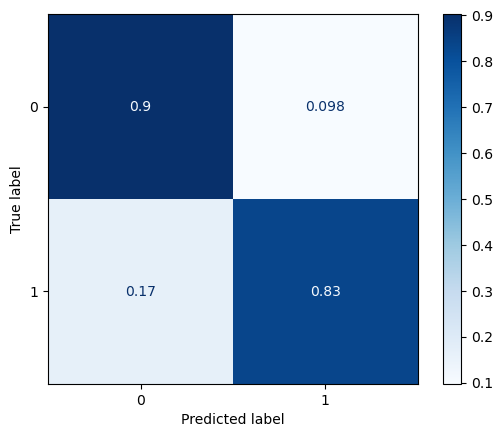

In [32]:
hgbc_model_smote = hgbc_model_pipeline[-1].fit(X_train_smote, y_train_smote)

y_pred = hgbc_model_smote.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

# HGBC: SMOTE vs. Leaving Data Imbalanced

---

Based on the results of my models, the **F1 scores** are very similar, with only a 1% difference between them. However, the models show more significant differences in their **precision** and **recall** scores.

Given that the primary business objective is to **maximize revenue and occupancy**, prioritizing a higher **recall** is critical. Our goal is to correctly identify as many cancellations as possible, even if it means misclassifying some reservations that would have actualized. While this may introduce operational challenges—such as managing room inventory and the risk of overselling—both models perform reasonably well and are designed to help minimize **false negatives** (missed cancellations).

The best-performing model in terms of recall is the one trained on the imbalanced dataset, using the `class_weights = balanced` argument. I will now utilize the `SHAP` package to identify the most impactful features and propose actionable next steps for the hotel to proactively prevent cancellations.

---

# SHAP Results Review: HistGradientBoostingClassifier

### Non-SMOTE'ed Modeling Approach

In [33]:
## Use only if using model pipeline without SMOTENC
X_train_xf = hgbc_model_pipeline.named_steps.preprocessor.fit_transform(X_train)
X_test_xf = hgbc_model_pipeline.named_steps.preprocessor.transform(X_test)

X_shap_train = shap.sample(X_train_xf, 500)
y_shap_train = y_train.loc[X_shap_train.index]

X_shap_test = shap.sample(X_test_xf, 500)
y_shap_test = y_test.loc[X_shap_test.index]

explainer = shap.Explainer(hgbc_model_pipeline.named_steps.classifier, X_shap_train)
# shap_values_train = explainer(X_shap_train)
shap_values_test = explainer(X_shap_test, check_additivity=False)

NameError: name 'shap' is not defined

### SMOTE-Based Modeling Approach

In [33]:
# ## Use only if using SMOTENC data and associated model

# X_train_xf = X_train_smote
# X_test_xf = X_test_transformed

# X_shap_train = shap.sample(X_train_xf, 500)
# y_shap_train = y_train_smote.loc[X_shap_train.index]

# X_shap_test = shap.sample(X_test_xf, 500)
# y_shap_test = y_test.loc[X_shap_test.index]

# explainer = shap.Explainer(hgbc_model_smote, X_shap_train)
# shap_values_test = explainer(X_shap_test)

In [35]:
print(shap_values_test.shape)

(500, 182)


## Summary Plot

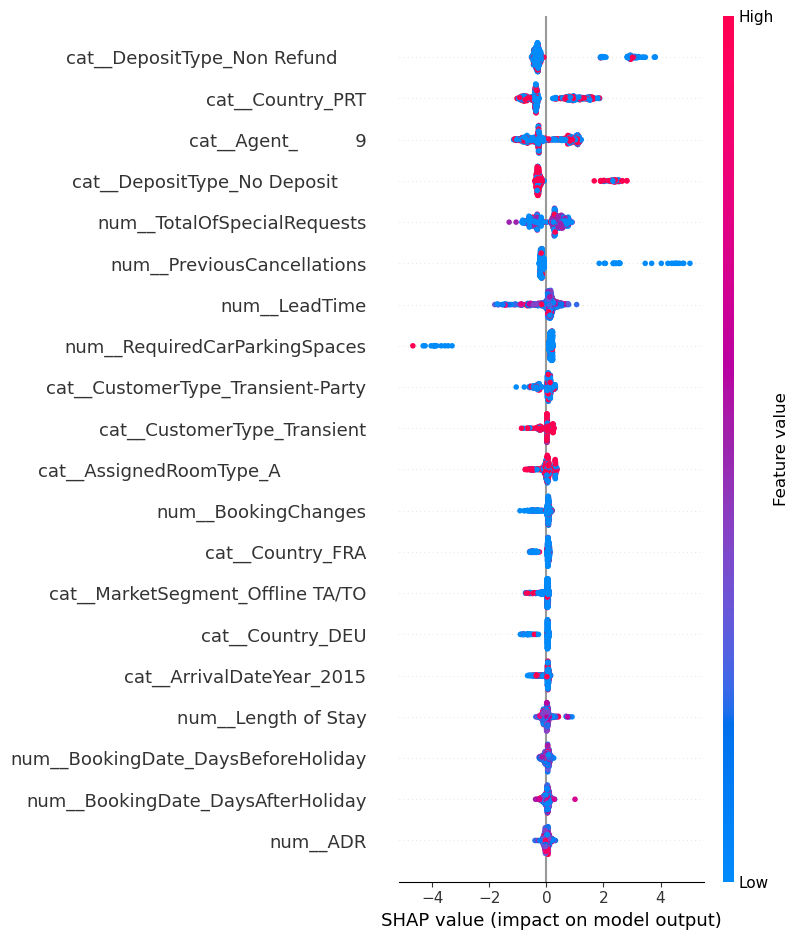

In [36]:
shap.summary_plot(shap_values_test, X_shap_train)

# Final Recommendations for Reducing Cancellations and Maximizing Occupancy

---

Based on the SHAP analysis of the HistGradientBoostingClassifier model, the following key actions are recommended to reduce cancellations and optimize revenue for the hotel:

1. *Prioritize High-Risk Guest Segments:*
   - **Portuguese guests** and **guests with a history of cancellations** should receive targeted engagement, including personalized offers, follow-up reminders, and flexible booking options.
   - Offer transportation incentives or perks to **non-parking guests** to increase commitment and reduce the likelihood of cancellations.

2. *Encourage Special Requests:*
   - Promote opportunities for guests to make **special requests** (e.g., room upgrades, dining preferences) during the booking process to increase engagement and reduce cancellations.

3. *Focus on Short Lead-Time Bookings:*
   - Provide **last-minute incentives** or **free cancellation deadlines** to encourage guests with short lead times to maintain their reservations.
   - For long lead-time bookings, maintain guest engagement with periodic offers to reduce cancellation risks over time.

4. *Leverage Automation and CRM Integration:*
   - Automate **personalized reminders, special offers, and engagement emails** based on guest behavior and risk profiles.
   - Integrate these predictive insights into the hotel's **CRM system** to build long-term guest loyalty and improve cancellation management.

5. *Monitor Key Metrics for Success:*
   - Track improvements in **cancellation rate**, **occupancy rate**, and **RevPAR** to evaluate the effectiveness of these strategies.
   - Regularly retrain and monitor the predictive model's performance to ensure continued accuracy in identifying high-risk guests.

By implementing these strategies, the hotel can significantly reduce cancellations, optimize room occupancy, and enhance overall guest satisfaction, all while balancing operational efficiency and revenue goals.

---